In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1566
0
(200571, 1, 36) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 260) (200571,) (200571,)
(50169, 1, 36) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 260) (50169,) (50169,)
(5803, 1, 36) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 260) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39536	valid-rmse:2.38792
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.984358	valid-rmse:0.983908
[100]	train-rmse:0.574339	valid-rmse:0.581343
[150]	train-rmse:0.490126	valid-rmse:0.503501
[200]	train-rmse:0.473833	valid-rmse:0.491822
[250]	train-rmse:0.468506	valid-rmse:0.490112
[300]	train-rmse:0.464778	valid-rmse:0.489867
[350]	train-rmse:0.462044	valid-rmse:0.489846
Stopping. Best iteration:
[330]	train-rmse:0.463095	valid-rmse:0.489817

0.21445741 0.23992074
[0.23992074]
-1 mean score 0.23992074
0.189931944013


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922717  0.006393  0.198814    7  2017-04-16
472     2.507290  2.536399 -0.029109  0.203599    1  2017-04-17
473     2.661330  2.660180  0.001150  0.216381    2  2017-04-18
474     2.754815  2.740077  0.014738  0.187332    3  2017-04-19
475     2.713762  2.709836  0.003926  0.209870    4  2017-04-20
476     2.999000  2.985113  0.013887  0.145678    5  2017-04-21
477     3.075529  3.079963 -0.004434  0.167849    6  2017-04-22

0.189931944013


pred         y     error    error2  day        date
dayidx                                                         
471     2.922717  2.929110  0.006393  0.198814    7  2017-04-16
472     2.536399  2.507290 -0.029109  0.203599    1  2017-04-17
473     2.660180  2.661330  0.001150  0.216381    2  2017-04-18
474     2.740077  2.754815  0.014738  0.187332    3  2017-04-19
475     2.709836  2.713762  0.003926  0.209870    4  2017-04-20
476     2.985113  2.999000  0.013887  0.145678    5  2017-04-21
477     3.079963  3.075529 -0.004434  0.167849    6  2017-04-22

(829, 260)


In [ ]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200346, 2) (50111, 2)
train/valid # (200346, 2) (50111, 2)
rand split across time
train has 200346 records out of 389630 records
valid has 50111 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200346, 1, 36) (200346, 7, 32) (200346, 1) (200346, 1)
(200346, 260) (200346,) (200346,)
(50111, 1, 36) (50111, 7, 32) (50111, 1) (50111, 1)
(50111, 260) (50111,) (50111,)
(6632, 1, 36) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 260) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39514	valid-rmse:2.38777
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986806	valid-rmse:0.989041
[100]	train-rmse:0.579118	valid-rmse:0.588976
[150]	train-rmse:0.496024	valid-rmse:0.51139
[200]	train-rmse:0.480102	valid-rmse:0.499529
[250]	train-rmse:0.474829	valid-rmse:0.497801
[300]	train-rmse:0.470962	valid-rmse:0.497575
[350]	train-rmse:0.467983	valid-rmse:0.497601
Stopping. Best iteration:
[308]	train-rmse:0.470589	valid-rmse:0.497567

0.2214538 0.24757293
[0.24757293]
-1 mean score 0.24757293
0.195496663451


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914983  0.014127  0.210027    7  2017-04-16
472     2.507290  2.534960 -0.027669  0.207386    1  2017-04-17
473     2.661330  2.650899  0.010431  0.220273    2  2017-04-18
474     2.754815  2.732020  0.022795  0.195571    3  2017-04-19
475     2.713762  2.711467  0.002295  0.217805    4  2017-04-20
476     2.999000  2.990758  0.008242  0.149043    5  2017-04-21
477     3.075529  3.068568  0.006962  0.168371    6  2017-04-22

0.195496663451


pred         y     error    error2  day        date
dayidx                                                         
471     2.914983  2.929110  0.014127  0.210027    7  2017-04-16
472     2.534960  2.507290 -0.027669  0.207386    1  2017-04-17
473     2.650899  2.661330  0.010431  0.220273    2  2017-04-18
474     2.732020  2.754815  0.022795  0.195571    3  2017-04-19
475     2.711467  2.713762  0.002295  0.217805    4  2017-04-20
476     2.990758  2.999000  0.008242  0.149043    5  2017-04-21
477     3.068568  3.075529  0.006962  0.168371    6  2017-04-22

(829, 260)


3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200167, 2) (50063, 2)
train/valid # (200167, 2) (50063, 2)
rand split across time
train has 200167 records out of 389630 records
valid has 50063 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1563
0
(200167, 1, 36) (200167, 7, 32) (200167, 1) (200167, 1)
(200167, 260) (200167,) (200167,)
(50063, 1, 36) (50063, 7, 32) (50063, 1) (50063, 1)
(50063, 260) (50063,) (50063,)
(7461, 1, 36) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 260) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39495	valid-rmse:2.38744
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987687	valid-rmse:0.988631
[100]	train-rmse:0.580893	valid-rmse:0.589629
[150]	train-rmse:0.497876	valid-rmse:0.513019
[200]	train-rmse:0.481992	valid-rmse:0.501628
[250]	train-rmse:0.476519	valid-rmse:0.50009
[300]	train-rmse:0.473067	valid-rmse:0.499855
[350]	train-rmse:0.469994	valid-rmse:0.499826
Stopping. Best iteration:
[342]	train-rmse:0.470558	valid-rmse:0.499808

0.2214252 0.24980778
[0.24980778]
-1 mean score 0.24980778
0.197395250201


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900428  0.028682  0.212844    7  2017-04-16
472     2.507290  2.531273 -0.023983  0.207595    1  2017-04-17
473     2.661330  2.642651  0.018679  0.234255    2  2017-04-18
474     2.754815  2.745361  0.009453  0.191288    3  2017-04-19
475     2.713762  2.709373  0.004389  0.216698    4  2017-04-20
476     2.999000  2.993643  0.005357  0.149750    5  2017-04-21
477     3.075529  3.071322  0.004207  0.169336    6  2017-04-22

0.197395250201


pred         y     error    error2  day        date
dayidx                                                         
471     2.900428  2.929110  0.028682  0.212844    7  2017-04-16
472     2.531273  2.507290 -0.023983  0.207595    1  2017-04-17
473     2.642651  2.661330  0.018679  0.234255    2  2017-04-18
474     2.745361  2.754815  0.009453  0.191288    3  2017-04-19
475     2.709373  2.713762  0.004389  0.216698    4  2017-04-20
476     2.993643  2.999000  0.005357  0.149750    5  2017-04-21
477     3.071322  3.075529  0.004207  0.169336    6  2017-04-22

(829, 260)


4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200008, 2) (50020, 2)
train/valid # (200008, 2) (50020, 2)
rand split across time
train has 200008 records out of 389630 records
valid has 50020 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200008, 1, 36) (200008, 7, 32) (200008, 1) (200008, 1)
(200008, 260) (200008,) (200008,)
(50020, 1, 36) (50020, 7, 32) (50020, 1) (50020, 1)
(50020, 260) (50020,) (50020,)
(8290, 1, 36) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 260) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39494	valid-rmse:2.38748
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988289	valid-rmse:0.990033
[100]	train-rmse:0.581986	valid-rmse:0.591435
[150]	train-rmse:0.499322	valid-rmse:0.514538
[200]	train-rmse:0.483455	valid-rmse:0.502973
[250]	train-rmse:0.47801	valid-rmse:0.501307
[300]	train-rmse:0.474446	valid-rmse:0.500999
[350]	train-rmse:0.471419	valid-rmse:0.500992
Stopping. Best iteration:
[325]	train-rmse:0.472852	valid-rmse:0.500965

0.22358873 0.2509658
[0.2509658]
-1 mean score 0.2509658
0.197432607412


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902662  0.026448  0.209376    7  2017-04-16
472     2.507290  2.522340 -0.015050  0.210062    1  2017-04-17
473     2.661330  2.637480  0.023850  0.230089    2  2017-04-18
474     2.754815  2.729592  0.025223  0.194467    3  2017-04-19
475     2.713762  2.709369  0.004392  0.216355    4  2017-04-20
476     2.999000  2.983350  0.015650  0.153197    5  2017-04-21
477     3.075529  3.067977  0.007552  0.168482    6  2017-04-22

0.197432607412


pred         y     error    error2  day        date
dayidx                                                         
471     2.902662  2.929110  0.026448  0.209376    7  2017-04-16
472     2.522340  2.507290 -0.015050  0.210062    1  2017-04-17
473     2.637480  2.661330  0.023850  0.230089    2  2017-04-18
474     2.729592  2.754815  0.025223  0.194467    3  2017-04-19
475     2.709369  2.713762  0.004392  0.216355    4  2017-04-20
476     2.983350  2.999000  0.015650  0.153197    5  2017-04-21
477     3.067977  3.075529  0.007552  0.168482    6  2017-04-22

(829, 260)


5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199805, 2) (49971, 2)
train/valid # (199805, 2) (49971, 2)
rand split across time
train has 199805 records out of 389630 records
valid has 49971 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1560
0
(199805, 1, 36) (199805, 7, 32) (199805, 1) (199805, 1)
(199805, 260) (199805,) (199805,)
(49971, 1, 36) (49971, 7, 32) (49971, 1) (49971, 1)
(49971, 260) (49971,) (49971,)
(9119, 1, 36) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 260) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39518	valid-rmse:2.38771
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989033	valid-rmse:0.990782
[100]	train-rmse:0.583085	valid-rmse:0.592731
[150]	train-rmse:0.500279	valid-rmse:0.516084
[200]	train-rmse:0.484502	valid-rmse:0.504704
[250]	train-rmse:0.479259	valid-rmse:0.503067
[300]	train-rmse:0.475534	valid-rmse:0.502821
[350]	train-rmse:0.472496	valid-rmse:0.502767
Stopping. Best iteration:
[340]	train-rmse:0.473011	valid-rmse:0.502751

0.223739 0.2527585
[0.2527585]
-1 mean score 0.2527585
0.199111148715


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901861  0.027249  0.211488    7  2017-04-16
472     2.507290  2.529436 -0.022146  0.216474    1  2017-04-17
473     2.661330  2.630643  0.030687  0.231521    2  2017-04-18
474     2.754815  2.730462  0.024353  0.194850    3  2017-04-19
475     2.713762  2.704390  0.009372  0.218677    4  2017-04-20
476     2.999000  2.986054  0.012946  0.153373    5  2017-04-21
477     3.075529  3.068787  0.006743  0.167396    6  2017-04-22

0.199111148715


pred         y     error    error2  day        date
dayidx                                                         
471     2.901861  2.929110  0.027249  0.211488    7  2017-04-16
472     2.529436  2.507290 -0.022146  0.216474    1  2017-04-17
473     2.630643  2.661330  0.030687  0.231521    2  2017-04-18
474     2.730462  2.754815  0.024353  0.194850    3  2017-04-19
475     2.704390  2.713762  0.009372  0.218677    4  2017-04-20
476     2.986054  2.999000  0.012946  0.153373    5  2017-04-21
477     3.068787  3.075529  0.006743  0.167396    6  2017-04-22

(829, 260)


6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 15.133374
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199592, 2) (49921, 2)
train/valid # (199592, 2) (49921, 2)
rand split across time
train has 199592 records out of 389630 records
valid has 49921 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199592, 1, 36) (199592, 7, 32) (199592, 1) (199592, 1)
(199592, 260) (199592,) (199592,)
(49921, 1, 36) (49921, 7, 32) (49921, 1) (49921, 1)
(49921, 260) (49921,) (49921,)
(9948, 1, 36) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 260) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39531	valid-rmse:2.38785
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989573	valid-rmse:0.98723
[100]	train-rmse:0.584281	valid-rmse:0.590635
[150]	train-rmse:0.501725	valid-rmse:0.516002
[200]	train-rmse:0.485824	valid-rmse:0.505487
[250]	train-rmse:0.480762	valid-rmse:0.5042
[300]	train-rmse:0.477887	valid-rmse:0.504133
Stopping. Best iteration:
[294]	train-rmse:0.478097	valid-rmse:0.504126

0.22857696 0.2541433
[0.2541433]
-1 mean score 0.2541433
0.205386266112


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906936  0.022174  0.220706    7  2017-04-16
472     2.507290  2.537112 -0.029821  0.221697    1  2017-04-17
473     2.661330  2.633676  0.027654  0.243503    2  2017-04-18
474     2.754815  2.727213  0.027601  0.197464    3  2017-04-19
475     2.713762  2.712282  0.001480  0.225411    4  2017-04-20
476     2.999000  2.972206  0.026794  0.157437    5  2017-04-21
477     3.075529  3.076701 -0.001172  0.171486    6  2017-04-22

0.205386266112


pred         y     error    error2  day        date
dayidx                                                         
471     2.906936  2.929110  0.022174  0.220706    7  2017-04-16
472     2.537112  2.507290 -0.029821  0.221697    1  2017-04-17
473     2.633676  2.661330  0.027654  0.243503    2  2017-04-18
474     2.727213  2.754815  0.027601  0.197464    3  2017-04-19
475     2.712282  2.713762  0.001480  0.225411    4  2017-04-20
476     2.972206  2.999000  0.026794  0.157437    5  2017-04-21
477     3.076701  3.075529 -0.001172  0.171486    6  2017-04-22

(829, 260)


7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 16.310143
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199370, 2) (49869, 2)
train/valid # (199370, 2) (49869, 2)
rand split across time
train has 199370 records out of 389630 records
valid has 49869 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199370, 1, 36) (199370, 7, 32) (199370, 1) (199370, 1)
(199370, 260) (199370,) (199370,)
(49869, 1, 36) (49869, 7, 32) (49869, 1) (49869, 1)
(49869, 260) (49869,) (49869,)
(10777, 1, 36) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 260) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39547	valid-rmse:2.38799
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990474	valid-rmse:0.992558
[100]	train-rmse:0.585706	valid-rmse:0.595812
[150]	train-rmse:0.50334	valid-rmse:0.519665
[200]	train-rmse:0.487371	valid-rmse:0.508296
[250]	train-rmse:0.482104	valid-rmse:0.50668
[300]	train-rmse:0.47911	valid-rmse:0.506496
[350]	train-rmse:0.476381	valid-rmse:0.506562
Stopping. Best iteration:
[311]	train-rmse:0.478486	valid-rmse:0.506462

0.22894911 0.25650346
[0.25650346]
-1 mean score 0.25650346
0.206318065524


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901807  0.027303  0.218996    7  2017-04-16
472     2.507290  2.546539 -0.039249  0.225950    1  2017-04-17
473     2.661330  2.641371  0.019959  0.243369    2  2017-04-18
474     2.754815  2.729842  0.024973  0.200163    3  2017-04-19
475     2.713762  2.711614  0.002148  0.225676    4  2017-04-20
476     2.999000  2.980340  0.018660  0.154210    5  2017-04-21
477     3.075529  3.087679 -0.012150  0.175862    6  2017-04-22

0.206318065524


pred         y     error    error2  day        date
dayidx                                                         
471     2.901807  2.929110  0.027303  0.218996    7  2017-04-16
472     2.546539  2.507290 -0.039249  0.225950    1  2017-04-17
473     2.641371  2.661330  0.019959  0.243369    2  2017-04-18
474     2.729842  2.754815  0.024973  0.200163    3  2017-04-19
475     2.711614  2.713762  0.002148  0.225676    4  2017-04-20
476     2.980340  2.999000  0.018660  0.154210    5  2017-04-21
477     3.087679  3.075529 -0.012150  0.175862    6  2017-04-22

(829, 260)


8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 17.574337
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199138, 2) (49811, 2)
train/valid # (199138, 2) (49811, 2)
rand split across time
train has 199138 records out of 389630 records
valid has 49811 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1555
0
(199138, 1, 36) (199138, 7, 32) (199138, 1) (199138, 1)
(199138, 260) (199138,) (199138,)
(49811, 1, 36) (49811, 7, 32) (49811, 1) (49811, 1)
(49811, 260) (49811,) (49811,)
(11606, 1, 36) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 260) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39532	valid-rmse:2.38804
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991854	valid-rmse:0.993032
[100]	train-rmse:0.588333	valid-rmse:0.59843
[150]	train-rmse:0.50654	valid-rmse:0.5235
[200]	train-rmse:0.490697	valid-rmse:0.512478
[250]	train-rmse:0.485789	valid-rmse:0.51101
[300]	train-rmse:0.482164	valid-rmse:0.510816
[350]	train-rmse:0.479373	valid-rmse:0.510858
Stopping. Best iteration:
[304]	train-rmse:0.48195	valid-rmse:0.510795

0.23227623 0.2609117
[0.2609117]
-1 mean score 0.2609117
0.210282832384


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915596  0.013514  0.227720    7  2017-04-16
472     2.507290  2.545778 -0.038487  0.223498    1  2017-04-17
473     2.661330  2.643313  0.018016  0.246116    2  2017-04-18
474     2.754815  2.731250  0.023564  0.208337    3  2017-04-19
475     2.713762  2.710198  0.003563  0.228494    4  2017-04-20
476     2.999000  2.968401  0.030599  0.163250    5  2017-04-21
477     3.075529  3.085207 -0.009678  0.174565    6  2017-04-22

0.210282832384


pred         y     error    error2  day        date
dayidx                                                         
471     2.915596  2.929110  0.013514  0.227720    7  2017-04-16
472     2.545778  2.507290 -0.038487  0.223498    1  2017-04-17
473     2.643313  2.661330  0.018016  0.246116    2  2017-04-18
474     2.731250  2.754815  0.023564  0.208337    3  2017-04-19
475     2.710198  2.713762  0.003563  0.228494    4  2017-04-20
476     2.968401  2.999000  0.030599  0.163250    5  2017-04-21
477     3.085207  3.075529 -0.009678  0.174565    6  2017-04-22

(829, 260)


9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 18.806503
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198911, 2) (49756, 2)
train/valid # (198911, 2) (49756, 2)
rand split across time
train has 198911 records out of 389630 records
valid has 49756 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1553
0
(198911, 1, 36) (198911, 7, 32) (198911, 1) (198911, 1)
(198911, 260) (198911,) (198911,)
(49756, 1, 36) (49756, 7, 32) (49756, 1) (49756, 1)
(49756, 260) (49756,) (49756,)
(12435, 1, 36) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 260) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39503	valid-rmse:2.38772
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992914	valid-rmse:0.993632
[100]	train-rmse:0.590459	valid-rmse:0.599728
[150]	train-rmse:0.508673	valid-rmse:0.525134
[200]	train-rmse:0.492563	valid-rmse:0.514183
[250]	train-rmse:0.487066	valid-rmse:0.512752
[300]	train-rmse:0.483511	valid-rmse:0.512536
[350]	train-rmse:0.481016	valid-rmse:0.512569
Stopping. Best iteration:
[313]	train-rmse:0.482802	valid-rmse:0.512524

0.2330974 0.26268098
[0.26268098]
-1 mean score 0.26268098
0.209765926003


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912741  0.016369  0.226624    7  2017-04-16
472     2.507290  2.549812 -0.042522  0.220649    1  2017-04-17
473     2.661330  2.656776  0.004554  0.246340    2  2017-04-18
474     2.754815  2.726124  0.028690  0.212160    3  2017-04-19
475     2.713762  2.714203 -0.000441  0.227474    4  2017-04-20
476     2.999000  2.970406  0.028594  0.159994    5  2017-04-21
477     3.075529  3.079860 -0.004330  0.175120    6  2017-04-22

0.209765926003


pred         y     error    error2  day        date
dayidx                                                         
471     2.912741  2.929110  0.016369  0.226624    7  2017-04-16
472     2.549812  2.507290 -0.042522  0.220649    1  2017-04-17
473     2.656776  2.661330  0.004554  0.246340    2  2017-04-18
474     2.726124  2.754815  0.028690  0.212160    3  2017-04-19
475     2.714203  2.713762 -0.000441  0.227474    4  2017-04-20
476     2.970406  2.999000  0.028594  0.159994    5  2017-04-21
477     3.079860  3.075529 -0.004330  0.175120    6  2017-04-22

(829, 260)


10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 19.926521
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198741, 2) (49710, 2)
train/valid # (198741, 2) (49710, 2)
rand split across time
train has 198741 records out of 389630 records
valid has 49710 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1552
0
(198741, 1, 36) (198741, 7, 32) (198741, 1) (198741, 1)
(198741, 260) (198741,) (198741,)
(49710, 1, 36) (49710, 7, 32) (49710, 1) (49710, 1)
(49710, 260) (49710,) (49710,)
(13264, 1, 36) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 260) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39504	valid-rmse:2.38756
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993233	valid-rmse:0.994079
[100]	train-rmse:0.590961	valid-rmse:0.60098
[150]	train-rmse:0.509264	valid-rmse:0.526654
[200]	train-rmse:0.493456	valid-rmse:0.515834
[250]	train-rmse:0.488176	valid-rmse:0.514422
[300]	train-rmse:0.484531	valid-rmse:0.514199
[350]	train-rmse:0.481737	valid-rmse:0.514186
Stopping. Best iteration:
[304]	train-rmse:0.484223	valid-rmse:0.514174

0.23447159 0.26437464
[0.26437464]
-1 mean score 0.26437464
0.210765838623


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908616  0.020494  0.227525    7  2017-04-16
472     2.507290  2.535872 -0.028582  0.221536    1  2017-04-17
473     2.661330  2.659191  0.002139  0.255328    2  2017-04-18
474     2.754815  2.735787  0.019028  0.210352    3  2017-04-19
475     2.713762  2.717556 -0.003794  0.226034    4  2017-04-20
476     2.999000  2.973706  0.025294  0.160411    5  2017-04-21
477     3.075529  3.085261 -0.009732  0.174176    6  2017-04-22

0.210765838623


pred         y     error    error2  day        date
dayidx                                                         
471     2.908616  2.929110  0.020494  0.227525    7  2017-04-16
472     2.535872  2.507290 -0.028582  0.221536    1  2017-04-17
473     2.659191  2.661330  0.002139  0.255328    2  2017-04-18
474     2.735787  2.754815  0.019028  0.210352    3  2017-04-19
475     2.717556  2.713762 -0.003794  0.226034    4  2017-04-20
476     2.973706  2.999000  0.025294  0.160411    5  2017-04-21
477     3.085261  3.075529 -0.009732  0.174176    6  2017-04-22

(829, 260)


11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 21.05768
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198559, 2) (49666, 2)
train/valid # (198559, 2) (49666, 2)
rand split across time
train has 198559 records out of 389630 records
valid has 49666 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198559, 1, 36) (198559, 7, 32) (198559, 1) (198559, 1)
(198559, 260) (198559,) (198559,)
(49666, 1, 36) (49666, 7, 32) (49666, 1) (49666, 1)
(49666, 260) (49666,) (49666,)
(14093, 1, 36) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 260) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39532	valid-rmse:2.38786
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993609	valid-rmse:0.99462
[100]	train-rmse:0.591665	valid-rmse:0.601739
[150]	train-rmse:0.510246	valid-rmse:0.527353
[200]	train-rmse:0.494612	valid-rmse:0.516596
[250]	train-rmse:0.489208	valid-rmse:0.515119
[300]	train-rmse:0.485494	valid-rmse:0.514952
[350]	train-rmse:0.482796	valid-rmse:0.514961
Stopping. Best iteration:
[323]	train-rmse:0.484165	valid-rmse:0.514914

0.23441614 0.2651367
[0.2651367]
-1 mean score 0.2651367
0.211217269301


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899549  0.029561  0.227104    7  2017-04-16
472     2.507290  2.542343 -0.035053  0.221702    1  2017-04-17
473     2.661330  2.657700  0.003630  0.253851    2  2017-04-18
474     2.754815  2.726836  0.027978  0.209646    3  2017-04-19
475     2.713762  2.728611 -0.014849  0.227813    4  2017-04-20
476     2.999000  2.978992  0.020008  0.163063    5  2017-04-21
477     3.075529  3.070409  0.005120  0.175342    6  2017-04-22

0.211217269301


pred         y     error    error2  day        date
dayidx                                                         
471     2.899549  2.929110  0.029561  0.227104    7  2017-04-16
472     2.542343  2.507290 -0.035053  0.221702    1  2017-04-17
473     2.657700  2.661330  0.003630  0.253851    2  2017-04-18
474     2.726836  2.754815  0.027978  0.209646    3  2017-04-19
475     2.728611  2.713762 -0.014849  0.227813    4  2017-04-20
476     2.978992  2.999000  0.020008  0.163063    5  2017-04-21
477     3.070409  3.075529  0.005120  0.175342    6  2017-04-22

(829, 260)


12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 22.115147
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198344, 2) (49614, 2)
train/valid # (198344, 2) (49614, 2)
rand split across time
train has 198344 records out of 389630 records
valid has 49614 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198344, 1, 36) (198344, 7, 32) (198344, 1) (198344, 1)
(198344, 260) (198344,) (198344,)
(49614, 1, 36) (49614, 7, 32) (49614, 1) (49614, 1)
(49614, 260) (49614,) (49614,)
(14922, 1, 36) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 260) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39552	valid-rmse:2.38813
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994326	valid-rmse:0.993992
[100]	train-rmse:0.592818	valid-rmse:0.601721
[150]	train-rmse:0.511625	valid-rmse:0.528192
[200]	train-rmse:0.495931	valid-rmse:0.517696
[250]	train-rmse:0.490677	valid-rmse:0.516344
[300]	train-rmse:0.487008	valid-rmse:0.516182
[350]	train-rmse:0.484161	valid-rmse:0.516213
Stopping. Best iteration:
[309]	train-rmse:0.486489	valid-rmse:0.51616

0.23667152 0.26642138
[0.26642138]
-1 mean score 0.26642138
0.212053567171


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897041  0.032069  0.232773    7  2017-04-16
472     2.507290  2.541133 -0.033842  0.217794    1  2017-04-17
473     2.661330  2.657913  0.003417  0.253947    2  2017-04-18
474     2.754815  2.723215  0.031600  0.213325    3  2017-04-19
475     2.713762  2.716918 -0.003157  0.227049    4  2017-04-20
476     2.999000  2.974683  0.024317  0.163915    5  2017-04-21
477     3.075529  3.071823  0.003706  0.175573    6  2017-04-22

0.212053567171


pred         y     error    error2  day        date
dayidx                                                         
471     2.897041  2.929110  0.032069  0.232773    7  2017-04-16
472     2.541133  2.507290 -0.033842  0.217794    1  2017-04-17
473     2.657913  2.661330  0.003417  0.253947    2  2017-04-18
474     2.723215  2.754815  0.031600  0.213325    3  2017-04-19
475     2.716918  2.713762 -0.003157  0.227049    4  2017-04-20
476     2.974683  2.999000  0.024317  0.163915    5  2017-04-21
477     3.071823  3.075529  0.003706  0.175573    6  2017-04-22

(829, 260)


13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 23.15517
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198132, 2) (49563, 2)
train/valid # (198132, 2) (49563, 2)
rand split across time
train has 198132 records out of 389630 records
valid has 49563 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1547
0
(198132, 1, 36) (198132, 7, 32) (198132, 1) (198132, 1)
(198132, 260) (198132,) (198132,)
(49563, 1, 36) (49563, 7, 32) (49563, 1) (49563, 1)
(49563, 260) (49563,) (49563,)
(15751, 1, 36) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 260) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39562	valid-rmse:2.38834
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99455	valid-rmse:0.991105
[100]	train-rmse:0.593151	valid-rmse:0.600011
[150]	train-rmse:0.511917	valid-rmse:0.528141
[200]	train-rmse:0.496287	valid-rmse:0.518577
[250]	train-rmse:0.491018	valid-rmse:0.517525
[300]	train-rmse:0.487444	valid-rmse:0.517472
Stopping. Best iteration:
[296]	train-rmse:0.487685	valid-rmse:0.517466

0.23783694 0.26777095
[0.26777095]
-1 mean score 0.26777095
0.212258830667


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901465  0.027645  0.228619    7  2017-04-16
472     2.507290  2.540047 -0.032757  0.223856    1  2017-04-17
473     2.661330  2.661470 -0.000141  0.250242    2  2017-04-18
474     2.754815  2.728116  0.026698  0.212970    3  2017-04-19
475     2.713762  2.723527 -0.009766  0.231410    4  2017-04-20
476     2.999000  2.982357  0.016642  0.162604    5  2017-04-21
477     3.075529  3.063465  0.012064  0.176111    6  2017-04-22

0.212258830667


pred         y     error    error2  day        date
dayidx                                                         
471     2.901465  2.929110  0.027645  0.228619    7  2017-04-16
472     2.540047  2.507290 -0.032757  0.223856    1  2017-04-17
473     2.661470  2.661330 -0.000141  0.250242    2  2017-04-18
474     2.728116  2.754815  0.026698  0.212970    3  2017-04-19
475     2.723527  2.713762 -0.009766  0.231410    4  2017-04-20
476     2.982357  2.999000  0.016642  0.162604    5  2017-04-21
477     3.063465  3.075529  0.012064  0.176111    6  2017-04-22

(829, 260)


14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 24.22639
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197911, 2) (49506, 2)
train/valid # (197911, 2) (49506, 2)
rand split across time
train has 197911 records out of 389630 records
valid has 49506 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197911, 1, 36) (197911, 7, 32) (197911, 1) (197911, 1)
(197911, 260) (197911,) (197911,)
(49506, 1, 36) (49506, 7, 32) (49506, 1) (49506, 1)
(49506, 260) (49506,) (49506,)
(16580, 1, 36) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 260) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39568	valid-rmse:2.38848
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994937	valid-rmse:0.998305
[100]	train-rmse:0.593767	valid-rmse:0.606317
[150]	train-rmse:0.51247	valid-rmse:0.531725
[200]	train-rmse:0.496572	valid-rmse:0.520594
[250]	train-rmse:0.490977	valid-rmse:0.519006
[300]	train-rmse:0.487522	valid-rmse:0.518711
[350]	train-rmse:0.484634	valid-rmse:0.51871
Stopping. Best iteration:
[316]	train-rmse:0.486455	valid-rmse:0.518662

0.23663843 0.2690101
[0.2690101]
-1 mean score 0.2690101
0.211747199297


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892109  0.037001  0.233037    7  2017-04-16
472     2.507290  2.542729 -0.035439  0.220917    1  2017-04-17
473     2.661330  2.658954  0.002376  0.254033    2  2017-04-18
474     2.754815  2.722382  0.032433  0.217187    3  2017-04-19
475     2.713762  2.720695 -0.006934  0.226586    4  2017-04-20
476     2.999000  2.989987  0.009013  0.155965    5  2017-04-21
477     3.075529  3.069432  0.006098  0.174506    6  2017-04-22

0.211747199297


pred         y     error    error2  day        date
dayidx                                                         
471     2.892109  2.929110  0.037001  0.233037    7  2017-04-16
472     2.542729  2.507290 -0.035439  0.220917    1  2017-04-17
473     2.658954  2.661330  0.002376  0.254033    2  2017-04-18
474     2.722382  2.754815  0.032433  0.217187    3  2017-04-19
475     2.720695  2.713762 -0.006934  0.226586    4  2017-04-20
476     2.989987  2.999000  0.009013  0.155965    5  2017-04-21
477     3.069432  3.075529  0.006098  0.174506    6  2017-04-22

(829, 260)


15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 25.357664
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197678, 2) (49449, 2)
train/valid # (197678, 2) (49449, 2)
rand split across time
train has 197678 records out of 389630 records
valid has 49449 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197678, 1, 36) (197678, 7, 32) (197678, 1) (197678, 1)
(197678, 260) (197678,) (197678,)
(49449, 1, 36) (49449, 7, 32) (49449, 1) (49449, 1)
(49449, 260) (49449,) (49449,)
(17409, 1, 36) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 260) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39555	valid-rmse:2.38837
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99637	valid-rmse:0.997477
[100]	train-rmse:0.596489	valid-rmse:0.60726
[150]	train-rmse:0.51576	valid-rmse:0.533982
[200]	train-rmse:0.499667	valid-rmse:0.523347
[250]	train-rmse:0.494109	valid-rmse:0.521942
[300]	train-rmse:0.490578	valid-rmse:0.521758
[350]	train-rmse:0.487696	valid-rmse:0.521774
Stopping. Best iteration:
[312]	train-rmse:0.489943	valid-rmse:0.521734

0.2400441 0.272206
[0.272206]
-1 mean score 0.272206
0.215215548873


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907421  0.021689  0.237165    7  2017-04-16
472     2.507290  2.541665 -0.034374  0.225820    1  2017-04-17
473     2.661330  2.654141  0.007189  0.258288    2  2017-04-18
474     2.754815  2.719816  0.034999  0.213006    3  2017-04-19
475     2.713762  2.724985 -0.011224  0.231830    4  2017-04-20
476     2.999000  2.992172  0.006828  0.161428    5  2017-04-21
477     3.075529  3.070085  0.005445  0.178971    6  2017-04-22

0.215215548873


pred         y     error    error2  day        date
dayidx                                                         
471     2.907421  2.929110  0.021689  0.237165    7  2017-04-16
472     2.541665  2.507290 -0.034374  0.225820    1  2017-04-17
473     2.654141  2.661330  0.007189  0.258288    2  2017-04-18
474     2.719816  2.754815  0.034999  0.213006    3  2017-04-19
475     2.724985  2.713762 -0.011224  0.231830    4  2017-04-20
476     2.992172  2.999000  0.006828  0.161428    5  2017-04-21
477     3.070085  3.075529  0.005445  0.178971    6  2017-04-22

(829, 260)


16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 26.465925
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197447, 2) (49391, 2)
train/valid # (197447, 2) (49391, 2)
rand split across time
train has 197447 records out of 389630 records
valid has 49391 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197447, 1, 36) (197447, 7, 32) (197447, 1) (197447, 1)
(197447, 260) (197447,) (197447,)
(49391, 1, 36) (49391, 7, 32) (49391, 1) (49391, 1)
(49391, 260) (49391,) (49391,)
(18238, 1, 36) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 260) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39533	valid-rmse:2.38825
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997062	valid-rmse:1.00009
[100]	train-rmse:0.597926	valid-rmse:0.610601
[150]	train-rmse:0.517355	valid-rmse:0.537068
[200]	train-rmse:0.501452	valid-rmse:0.526205
[250]	train-rmse:0.496	valid-rmse:0.524693
[300]	train-rmse:0.49238	valid-rmse:0.52456
[350]	train-rmse:0.489908	valid-rmse:0.524627
Stopping. Best iteration:
[304]	train-rmse:0.492139	valid-rmse:0.524552

0.24220034 0.27515492
[0.27515492]
-1 mean score 0.27515492
0.217606276274


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898732  0.030378  0.239556    7  2017-04-16
472     2.507290  2.546855 -0.039565  0.226030    1  2017-04-17
473     2.661330  2.647162  0.014167  0.260237    2  2017-04-18
474     2.754815  2.708787  0.046027  0.216130    3  2017-04-19
475     2.713762  2.718551 -0.004789  0.234736    4  2017-04-20
476     2.999000  2.985780  0.013219  0.165427    5  2017-04-21
477     3.075529  3.062189  0.013341  0.181129    6  2017-04-22

0.217606276274


pred         y     error    error2  day        date
dayidx                                                         
471     2.898732  2.929110  0.030378  0.239556    7  2017-04-16
472     2.546855  2.507290 -0.039565  0.226030    1  2017-04-17
473     2.647162  2.661330  0.014167  0.260237    2  2017-04-18
474     2.708787  2.754815  0.046027  0.216130    3  2017-04-19
475     2.718551  2.713762 -0.004789  0.234736    4  2017-04-20
476     2.985780  2.999000  0.013219  0.165427    5  2017-04-21
477     3.062189  3.075529  0.013341  0.181129    6  2017-04-22

(829, 260)


17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 27.605818
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197289, 2) (49347, 2)
train/valid # (197289, 2) (49347, 2)
rand split across time
train has 197289 records out of 389630 records
valid has 49347 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197289, 1, 36) (197289, 7, 32) (197289, 1) (197289, 1)
(197289, 260) (197289,) (197289,)
(49347, 1, 36) (49347, 7, 32) (49347, 1) (49347, 1)
(49347, 260) (49347,) (49347,)
(19067, 1, 36) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 260) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39533	valid-rmse:2.38814
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99743	valid-rmse:0.998877
[100]	train-rmse:0.598366	valid-rmse:0.610022
[150]	train-rmse:0.517879	valid-rmse:0.537071
[200]	train-rmse:0.501944	valid-rmse:0.52654
[250]	train-rmse:0.496073	valid-rmse:0.525182
[300]	train-rmse:0.492858	valid-rmse:0.525021
[350]	train-rmse:0.490321	valid-rmse:0.525105
Stopping. Best iteration:
[307]	train-rmse:0.492455	valid-rmse:0.525001

0.24251154 0.27562603
[0.27562603]
-1 mean score 0.27562603
0.218309417367


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905444  0.023666  0.238466    7  2017-04-16
472     2.507290  2.530855 -0.023565  0.223833    1  2017-04-17
473     2.661330  2.641820  0.019509  0.261446    2  2017-04-18
474     2.754815  2.709571  0.045244  0.221963    3  2017-04-19
475     2.713762  2.713971 -0.000209  0.232043    4  2017-04-20
476     2.999000  2.989976  0.009024  0.168041    5  2017-04-21
477     3.075529  3.057604  0.017925  0.182373    6  2017-04-22

0.218309417367


pred         y     error    error2  day        date
dayidx                                                         
471     2.905444  2.929110  0.023666  0.238466    7  2017-04-16
472     2.530855  2.507290 -0.023565  0.223833    1  2017-04-17
473     2.641820  2.661330  0.019509  0.261446    2  2017-04-18
474     2.709571  2.754815  0.045244  0.221963    3  2017-04-19
475     2.713971  2.713762 -0.000209  0.232043    4  2017-04-20
476     2.989976  2.999000  0.009024  0.168041    5  2017-04-21
477     3.057604  3.075529  0.017925  0.182373    6  2017-04-22

(829, 260)


18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 28.75126
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197099, 2) (49301, 2)
train/valid # (197099, 2) (49301, 2)
rand split across time
train has 197099 records out of 389630 records
valid has 49301 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1539
0
(197099, 1, 36) (197099, 7, 32) (197099, 1) (197099, 1)
(197099, 260) (197099,) (197099,)
(49301, 1, 36) (49301, 7, 32) (49301, 1) (49301, 1)
(49301, 260) (49301,) (49301,)
(19896, 1, 36) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 260) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39553	valid-rmse:2.38844
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997926	valid-rmse:0.999109
[100]	train-rmse:0.599417	valid-rmse:0.610389
[150]	train-rmse:0.518939	valid-rmse:0.537642
[200]	train-rmse:0.502998	valid-rmse:0.527101
[250]	train-rmse:0.497203	valid-rmse:0.52581
[300]	train-rmse:0.493038	valid-rmse:0.525674
Stopping. Best iteration:
[290]	train-rmse:0.493689	valid-rmse:0.525661

0.24372873 0.27631938
[0.27631938]
-1 mean score 0.27631938
0.218075662851


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900636  0.028473  0.238630    7  2017-04-16
472     2.507290  2.529266 -0.021975  0.224116    1  2017-04-17
473     2.661330  2.636966  0.024364  0.258733    2  2017-04-18
474     2.754815  2.711030  0.043784  0.217818    3  2017-04-19
475     2.713762  2.704826  0.008936  0.238982    4  2017-04-20
476     2.999000  2.982693  0.016307  0.167150    5  2017-04-21
477     3.075529  3.055120  0.020410  0.181099    6  2017-04-22

0.218075662851


pred         y     error    error2  day        date
dayidx                                                         
471     2.900636  2.929110  0.028473  0.238630    7  2017-04-16
472     2.529266  2.507290 -0.021975  0.224116    1  2017-04-17
473     2.636966  2.661330  0.024364  0.258733    2  2017-04-18
474     2.711030  2.754815  0.043784  0.217818    3  2017-04-19
475     2.704826  2.713762  0.008936  0.238982    4  2017-04-20
476     2.982693  2.999000  0.016307  0.167150    5  2017-04-21
477     3.055120  3.075529  0.020410  0.181099    6  2017-04-22

(829, 260)


19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 29.798643
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196885, 2) (49250, 2)
train/valid # (196885, 2) (49250, 2)
rand split across time
train has 196885 records out of 389630 records
valid has 49250 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196885, 1, 36) (196885, 7, 32) (196885, 1) (196885, 1)
(196885, 260) (196885,) (196885,)
(49250, 1, 36) (49250, 7, 32) (49250, 1) (49250, 1)
(49250, 260) (49250,) (49250,)
(20725, 1, 36) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 260) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39569	valid-rmse:2.38852
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998254	valid-rmse:1.00072
[100]	train-rmse:0.599777	valid-rmse:0.612248
[150]	train-rmse:0.519187	valid-rmse:0.53936
[200]	train-rmse:0.503381	valid-rmse:0.528783
[250]	train-rmse:0.497694	valid-rmse:0.527393
[300]	train-rmse:0.493956	valid-rmse:0.527287
Stopping. Best iteration:
[268]	train-rmse:0.496085	valid-rmse:0.527268

0.24610046 0.27801195
[0.27801195]
-1 mean score 0.27801195
0.22143496573


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901734  0.027376  0.239648    7  2017-04-16
472     2.507290  2.530803 -0.023512  0.230032    1  2017-04-17
473     2.661330  2.629793  0.031537  0.257291    2  2017-04-18
474     2.754815  2.704927  0.049888  0.224391    3  2017-04-19
475     2.713762  2.702429  0.011333  0.240449    4  2017-04-20
476     2.999000  2.963211  0.035788  0.170802    5  2017-04-21
477     3.075529  3.050050  0.025480  0.187433    6  2017-04-22

0.22143496573


pred         y     error    error2  day        date
dayidx                                                         
471     2.901734  2.929110  0.027376  0.239648    7  2017-04-16
472     2.530803  2.507290 -0.023512  0.230032    1  2017-04-17
473     2.629793  2.661330  0.031537  0.257291    2  2017-04-18
474     2.704927  2.754815  0.049888  0.224391    3  2017-04-19
475     2.702429  2.713762  0.011333  0.240449    4  2017-04-20
476     2.963211  2.999000  0.035788  0.170802    5  2017-04-21
477     3.050050  3.075529  0.025480  0.187433    6  2017-04-22

(829, 260)


20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 30.796307
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196665, 2) (49196, 2)
train/valid # (196665, 2) (49196, 2)
rand split across time
train has 196665 records out of 389630 records
valid has 49196 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196665, 1, 36) (196665, 7, 32) (196665, 1) (196665, 1)
(196665, 260) (196665,) (196665,)
(49196, 1, 36) (49196, 7, 32) (49196, 1) (49196, 1)
(49196, 260) (49196,) (49196,)
(21554, 1, 36) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 260) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39572	valid-rmse:2.38866
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998399	valid-rmse:1.00099
[100]	train-rmse:0.59999	valid-rmse:0.612889
[150]	train-rmse:0.519482	valid-rmse:0.540033
[200]	train-rmse:0.503438	valid-rmse:0.529301
[250]	train-rmse:0.497784	valid-rmse:0.527822
[300]	train-rmse:0.494168	valid-rmse:0.527633
[350]	train-rmse:0.491089	valid-rmse:0.52764
Stopping. Best iteration:
[339]	train-rmse:0.491806	valid-rmse:0.527607

0.2418736 0.27836886
[0.27836886]
-1 mean score 0.27836886
0.218885049224


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920508  0.008602  0.237705    7  2017-04-16
472     2.507290  2.548224 -0.040934  0.229115    1  2017-04-17
473     2.661330  2.644211  0.017118  0.255580    2  2017-04-18
474     2.754815  2.715187  0.039628  0.217817    3  2017-04-19
475     2.713762  2.709405  0.004357  0.241962    4  2017-04-20
476     2.999000  2.971899  0.027101  0.167828    5  2017-04-21
477     3.075529  3.058978  0.016551  0.182189    6  2017-04-22

0.218885049224


pred         y     error    error2  day        date
dayidx                                                         
471     2.920508  2.929110  0.008602  0.237705    7  2017-04-16
472     2.548224  2.507290 -0.040934  0.229115    1  2017-04-17
473     2.644211  2.661330  0.017118  0.255580    2  2017-04-18
474     2.715187  2.754815  0.039628  0.217817    3  2017-04-19
475     2.709405  2.713762  0.004357  0.241962    4  2017-04-20
476     2.971899  2.999000  0.027101  0.167828    5  2017-04-21
477     3.058978  3.075529  0.016551  0.182189    6  2017-04-22

(829, 260)


21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 31.792852
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196439, 2) (49141, 2)
train/valid # (196439, 2) (49141, 2)
rand split across time
train has 196439 records out of 389630 records
valid has 49141 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1534
0
(196439, 1, 36) (196439, 7, 32) (196439, 1) (196439, 1)
(196439, 260) (196439,) (196439,)
(49141, 1, 36) (49141, 7, 32) (49141, 1) (49141, 1)
(49141, 260) (49141,) (49141,)
(22383, 1, 36) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 260) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39582	valid-rmse:2.38876
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998942	valid-rmse:1.0024
[100]	train-rmse:0.600862	valid-rmse:0.614729
[150]	train-rmse:0.520479	valid-rmse:0.541663
[200]	train-rmse:0.50459	valid-rmse:0.530746
[250]	train-rmse:0.498416	valid-rmse:0.529226
[300]	train-rmse:0.494328	valid-rmse:0.528993
[350]	train-rmse:0.491168	valid-rmse:0.529
Stopping. Best iteration:
[308]	train-rmse:0.493708	valid-rmse:0.528976

0.24374731 0.27981588
[0.27981588]
-1 mean score 0.27981588
0.221111625433


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892538  0.036572  0.243598    7  2017-04-16
472     2.507290  2.542932 -0.035642  0.234481    1  2017-04-17
473     2.661330  2.645570  0.015760  0.255153    2  2017-04-18
474     2.754815  2.714652  0.040163  0.219160    3  2017-04-19
475     2.713762  2.696721  0.017040  0.238816    4  2017-04-20
476     2.999000  2.966321  0.032679  0.174540    5  2017-04-21
477     3.075529  3.059126  0.016403  0.182034    6  2017-04-22

0.221111625433


pred         y     error    error2  day        date
dayidx                                                         
471     2.892538  2.929110  0.036572  0.243598    7  2017-04-16
472     2.542932  2.507290 -0.035642  0.234481    1  2017-04-17
473     2.645570  2.661330  0.015760  0.255153    2  2017-04-18
474     2.714652  2.754815  0.040163  0.219160    3  2017-04-19
475     2.696721  2.713762  0.017040  0.238816    4  2017-04-20
476     2.966321  2.999000  0.032679  0.174540    5  2017-04-21
477     3.059126  3.075529  0.016403  0.182034    6  2017-04-22

(829, 260)


22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 32.870983
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 389630 records
valid has 49086 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1532
0
(196206, 1, 36) (196206, 7, 32) (196206, 1) (196206, 1)
(196206, 260) (196206,) (196206,)
(49086, 1, 36) (49086, 7, 32) (49086, 1) (49086, 1)
(49086, 260) (49086,) (49086,)
(23212, 1, 36) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 260) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39579	valid-rmse:2.38879
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999898	valid-rmse:1.00235
[100]	train-rmse:0.602532	valid-rmse:0.615388
[150]	train-rmse:0.522485	valid-rmse:0.543037
[200]	train-rmse:0.506447	valid-rmse:0.532544
[250]	train-rmse:0.500829	valid-rmse:0.531062
[300]	train-rmse:0.496969	valid-rmse:0.530896
[350]	train-rmse:0.494163	valid-rmse:0.530925
Stopping. Best iteration:
[327]	train-rmse:0.495389	valid-rmse:0.530884

0.24541056 0.28183815
[0.28183815]
-1 mean score 0.28183815
0.218007400632


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908726  0.020384  0.232612    7  2017-04-16
472     2.507290  2.527563 -0.020272  0.231808    1  2017-04-17
473     2.661330  2.646650  0.014680  0.255143    2  2017-04-18
474     2.754815  2.724248  0.030567  0.216719    3  2017-04-19
475     2.713762  2.705467  0.008295  0.241502    4  2017-04-20
476     2.999000  2.967601  0.031399  0.168290    5  2017-04-21
477     3.075529  3.058015  0.017514  0.179978    6  2017-04-22

0.218007400632


pred         y     error    error2  day        date
dayidx                                                         
471     2.908726  2.929110  0.020384  0.232612    7  2017-04-16
472     2.527563  2.507290 -0.020272  0.231808    1  2017-04-17
473     2.646650  2.661330  0.014680  0.255143    2  2017-04-18
474     2.724248  2.754815  0.030567  0.216719    3  2017-04-19
475     2.705467  2.713762  0.008295  0.241502    4  2017-04-20
476     2.967601  2.999000  0.031399  0.168290    5  2017-04-21
477     3.058015  3.075529  0.017514  0.179978    6  2017-04-22

(829, 260)


23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 33.974537
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195972, 2) (49031, 2)
train/valid # (195972, 2) (49031, 2)
rand split across time
train has 195972 records out of 389630 records
valid has 49031 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(195972, 1, 36) (195972, 7, 32) (195972, 1) (195972, 1)
(195972, 260) (195972,) (195972,)
(49031, 1, 36) (49031, 7, 32) (49031, 1) (49031, 1)
(49031, 260) (49031,) (49031,)
(24041, 1, 36) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 260) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39554	valid-rmse:2.38847
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00055	valid-rmse:1.00314
[100]	train-rmse:0.603825	valid-rmse:0.616827
[150]	train-rmse:0.523866	valid-rmse:0.544554
[200]	train-rmse:0.507789	valid-rmse:0.533936
[250]	train-rmse:0.502309	valid-rmse:0.532422
[300]	train-rmse:0.498571	valid-rmse:0.532224
[350]	train-rmse:0.495627	valid-rmse:0.532238
Stopping. Best iteration:
[316]	train-rmse:0.497684	valid-rmse:0.532197

0.24768922 0.28323343
[0.28323343]
-1 mean score 0.28323343
0.218111306429


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907746  0.021364  0.232113    7  2017-04-16
472     2.507290  2.527952 -0.020662  0.228210    1  2017-04-17
473     2.661330  2.647026  0.014304  0.254991    2  2017-04-18
474     2.754815  2.723663  0.031152  0.219586    3  2017-04-19
475     2.713762  2.711496  0.002266  0.238792    4  2017-04-20
476     2.999000  2.966194  0.032805  0.171705    5  2017-04-21
477     3.075529  3.055842  0.019687  0.181383    6  2017-04-22

0.218111306429


pred         y     error    error2  day        date
dayidx                                                         
471     2.907746  2.929110  0.021364  0.232113    7  2017-04-16
472     2.527952  2.507290 -0.020662  0.228210    1  2017-04-17
473     2.647026  2.661330  0.014304  0.254991    2  2017-04-18
474     2.723663  2.754815  0.031152  0.219586    3  2017-04-19
475     2.711496  2.713762  0.002266  0.238792    4  2017-04-20
476     2.966194  2.999000  0.032805  0.171705    5  2017-04-21
477     3.055842  3.075529  0.019687  0.181383    6  2017-04-22

(829, 260)


24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 35.208443
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195805, 2) (48983, 2)
train/valid # (195805, 2) (48983, 2)
rand split across time
train has 195805 records out of 389630 records
valid has 48983 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1529
0
(195805, 1, 36) (195805, 7, 32) (195805, 1) (195805, 1)
(195805, 260) (195805,) (195805,)
(48983, 1, 36) (48983, 7, 32) (48983, 1) (48983, 1)
(48983, 260) (48983,) (48983,)
(24870, 1, 36) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 260) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39545	valid-rmse:2.3884
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00082	valid-rmse:1.00093
[100]	train-rmse:0.604429	valid-rmse:0.61544
[150]	train-rmse:0.524347	valid-rmse:0.544443
[200]	train-rmse:0.508405	valid-rmse:0.534618
[250]	train-rmse:0.502654	valid-rmse:0.53345
[300]	train-rmse:0.499132	valid-rmse:0.533397
[350]	train-rmse:0.495836	valid-rmse:0.533341
Stopping. Best iteration:
[328]	train-rmse:0.497304	valid-rmse:0.533311

0.24731117 0.28442067
[0.28442067]
-1 mean score 0.28442067
0.21875320375


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911540  0.017570  0.230019    7  2017-04-16
472     2.507290  2.523758 -0.016468  0.232197    1  2017-04-17
473     2.661330  2.643810  0.017520  0.254254    2  2017-04-18
474     2.754815  2.727799  0.027015  0.219578    3  2017-04-19
475     2.713762  2.713089  0.000673  0.240582    4  2017-04-20
476     2.999000  2.979284  0.019716  0.171257    5  2017-04-21
477     3.075529  3.059243  0.016286  0.183385    6  2017-04-22

0.21875320375


pred         y     error    error2  day        date
dayidx                                                         
471     2.911540  2.929110  0.017570  0.230019    7  2017-04-16
472     2.523758  2.507290 -0.016468  0.232197    1  2017-04-17
473     2.643810  2.661330  0.017520  0.254254    2  2017-04-18
474     2.727799  2.754815  0.027015  0.219578    3  2017-04-19
475     2.713089  2.713762  0.000673  0.240582    4  2017-04-20
476     2.979284  2.999000  0.019716  0.171257    5  2017-04-21
477     3.059243  3.075529  0.016286  0.183385    6  2017-04-22

(829, 260)


25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 36.335064
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195621, 2) (48937, 2)
train/valid # (195621, 2) (48937, 2)
rand split across time
train has 195621 records out of 389630 records
valid has 48937 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195621, 1, 36) (195621, 7, 32) (195621, 1) (195621, 1)
(195621, 260) (195621,) (195621,)
(48937, 1, 36) (48937, 7, 32) (48937, 1) (48937, 1)
(48937, 260) (48937,) (48937,)
(25699, 1, 36) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 260) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39569	valid-rmse:2.38844
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00126	valid-rmse:1.00275
[100]	train-rmse:0.60507	valid-rmse:0.617327
[150]	train-rmse:0.525225	valid-rmse:0.545786
[200]	train-rmse:0.509319	valid-rmse:0.535488
[250]	train-rmse:0.50375	valid-rmse:0.534132
[300]	train-rmse:0.50018	valid-rmse:0.533985
[350]	train-rmse:0.497028	valid-rmse:0.533986
Stopping. Best iteration:
[304]	train-rmse:0.499898	valid-rmse:0.533963

0.24989787 0.2851165
[0.2851165]
-1 mean score 0.2851165
0.221444576979


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908103  0.021007  0.232517    7  2017-04-16
472     2.507290  2.516044 -0.008753  0.236383    1  2017-04-17
473     2.661330  2.646960  0.014370  0.261231    2  2017-04-18
474     2.754815  2.710423  0.044392  0.222423    3  2017-04-19
475     2.713762  2.692259  0.021502  0.243324    4  2017-04-20
476     2.999000  2.980856  0.018144  0.170075    5  2017-04-21
477     3.075529  3.061759  0.013770  0.184159    6  2017-04-22

0.221444576979


pred         y     error    error2  day        date
dayidx                                                         
471     2.908103  2.929110  0.021007  0.232517    7  2017-04-16
472     2.516044  2.507290 -0.008753  0.236383    1  2017-04-17
473     2.646960  2.661330  0.014370  0.261231    2  2017-04-18
474     2.710423  2.754815  0.044392  0.222423    3  2017-04-19
475     2.692259  2.713762  0.021502  0.243324    4  2017-04-20
476     2.980856  2.999000  0.018144  0.170075    5  2017-04-21
477     3.061759  3.075529  0.013770  0.184159    6  2017-04-22

(829, 260)


26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 37.374123
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195402, 2) (48885, 2)
train/valid # (195402, 2) (48885, 2)
rand split across time
train has 195402 records out of 389630 records
valid has 48885 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195402, 1, 36) (195402, 7, 32) (195402, 1) (195402, 1)
(195402, 260) (195402,) (195402,)
(48885, 1, 36) (48885, 7, 32) (48885, 1) (48885, 1)
(48885, 260) (48885,) (48885,)
(26528, 1, 36) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 260) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39593	valid-rmse:2.38868
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00176	valid-rmse:1.00283
[100]	train-rmse:0.605878	valid-rmse:0.617859
[150]	train-rmse:0.52608	valid-rmse:0.546558
[200]	train-rmse:0.510161	valid-rmse:0.536335
[250]	train-rmse:0.504154	valid-rmse:0.535077
[300]	train-rmse:0.500491	valid-rmse:0.535005
Stopping. Best iteration:
[284]	train-rmse:0.501503	valid-rmse:0.534965

0.25150478 0.28618768
[0.28618768]
-1 mean score 0.28618768
0.22474911809


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901580  0.027530  0.247026    7  2017-04-16
472     2.507290  2.527224 -0.019934  0.235428    1  2017-04-17
473     2.661330  2.644300  0.017029  0.263362    2  2017-04-18
474     2.754815  2.710758  0.044056  0.224144    3  2017-04-19
475     2.713762  2.695856  0.017905  0.245750    4  2017-04-20
476     2.999000  2.972876  0.026124  0.173583    5  2017-04-21
477     3.075529  3.061044  0.014485  0.183951    6  2017-04-22

0.22474911809


pred         y     error    error2  day        date
dayidx                                                         
471     2.901580  2.929110  0.027530  0.247026    7  2017-04-16
472     2.527224  2.507290 -0.019934  0.235428    1  2017-04-17
473     2.644300  2.661330  0.017029  0.263362    2  2017-04-18
474     2.710758  2.754815  0.044056  0.224144    3  2017-04-19
475     2.695856  2.713762  0.017905  0.245750    4  2017-04-20
476     2.972876  2.999000  0.026124  0.173583    5  2017-04-21
477     3.061044  3.075529  0.014485  0.183951    6  2017-04-22

(829, 260)


27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 38.450596
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195183, 2) (48836, 2)
train/valid # (195183, 2) (48836, 2)
rand split across time
train has 195183 records out of 389630 records
valid has 48836 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1524
0
(195183, 1, 36) (195183, 7, 32) (195183, 1) (195183, 1)
(195183, 260) (195183,) (195183,)
(48836, 1, 36) (48836, 7, 32) (48836, 1) (48836, 1)
(48836, 260) (48836,) (48836,)
(27357, 1, 36) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 260) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39613	valid-rmse:2.38875
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00197	valid-rmse:1.00231
[100]	train-rmse:0.606005	valid-rmse:0.617748
[150]	train-rmse:0.5263	valid-rmse:0.547018
[200]	train-rmse:0.510471	valid-rmse:0.537122
[250]	train-rmse:0.50452	valid-rmse:0.536021
[300]	train-rmse:0.501026	valid-rmse:0.53593
Stopping. Best iteration:
[298]	train-rmse:0.501153	valid-rmse:0.535927

0.25115412 0.28721792
[0.28721792]
-1 mean score 0.28721792
0.222887068987


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889819  0.039291  0.238660    7  2017-04-16
472     2.507290  2.528507 -0.021216  0.241961    1  2017-04-17
473     2.661330  2.654259  0.007071  0.261040    2  2017-04-18
474     2.754815  2.723581  0.031233  0.221388    3  2017-04-19
475     2.713762  2.697459  0.016302  0.242244    4  2017-04-20
476     2.999000  2.964583  0.034417  0.171873    5  2017-04-21
477     3.075529  3.064187  0.011342  0.183044    6  2017-04-22

0.222887068987


pred         y     error    error2  day        date
dayidx                                                         
471     2.889819  2.929110  0.039291  0.238660    7  2017-04-16
472     2.528507  2.507290 -0.021216  0.241961    1  2017-04-17
473     2.654259  2.661330  0.007071  0.261040    2  2017-04-18
474     2.723581  2.754815  0.031233  0.221388    3  2017-04-19
475     2.697459  2.713762  0.016302  0.242244    4  2017-04-20
476     2.964583  2.999000  0.034417  0.171873    5  2017-04-21
477     3.064187  3.075529  0.011342  0.183044    6  2017-04-22

(829, 260)


28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 39.47981
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194956, 2) (48782, 2)
train/valid # (194956, 2) (48782, 2)
rand split across time
train has 194956 records out of 389630 records
valid has 48782 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(194956, 1, 36) (194956, 7, 32) (194956, 1) (194956, 1)
(194956, 260) (194956,) (194956,)
(48782, 1, 36) (48782, 7, 32) (48782, 1) (48782, 1)
(48782, 260) (48782,) (48782,)
(28186, 1, 36) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 260) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39627	valid-rmse:2.3889
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0021	valid-rmse:1.00355
[200]	train-rmse:0.512569	valid-rmse:0.540277
[250]	train-rmse:0.506774	valid-rmse:0.539022
[300]	train-rmse:0.502801	valid-rmse:0.539075
Stopping. Best iteration:
[254]	train-rmse:0.506409	valid-rmse:0.538997

0.2564496 0.29051813
[0.29051813]
-1 mean score 0.29051813
0.22509123385


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888192  0.040918  0.239234    7  2017-04-16
472     2.507290  2.521149 -0.013859  0.236048    1  2017-04-17
473     2.661330  2.639694  0.021636  0.265293    2  2017-04-18
474     2.754815  2.713212  0.041603  0.229150    3  2017-04-19
475     2.713762  2.693516  0.020246  0.245430    4  2017-04-20
476     2.999000  2.975289  0.023711  0.174042    5  2017-04-21
477     3.075529  3.059509  0.016021  0.186443    6  2017-04-22

0.22509123385


pred         y     error    error2  day        date
dayidx                                                         
471     2.888192  2.929110  0.040918  0.239234    7  2017-04-16
472     2.521149  2.507290 -0.013859  0.236048    1  2017-04-17
473     2.639694  2.661330  0.021636  0.265293    2  2017-04-18
474     2.713212  2.754815  0.041603  0.229150    3  2017-04-19
475     2.693516  2.713762  0.020246  0.245430    4  2017-04-20
476     2.975289  2.999000  0.023711  0.174042    5  2017-04-21
477     3.059509  3.075529  0.016021  0.186443    6  2017-04-22

(829, 260)


30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 41.98585
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194492, 2) (48667, 2)
train/valid # (194492, 2) (48667, 2)
rand split across time
train has 194492 records out of 389630 records
valid has 48667 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194492, 1, 36) (194492, 7, 32) (194492, 1) (194492, 1)
(194492, 260) (194492,) (194492,)
(48667, 1, 36) (48667, 7, 32) (48667, 1) (48667, 1)
(48667, 260) (48667,) (48667,)
(29844, 1, 36) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 260) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39588	valid-rmse:2.38841
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0041	valid-rmse:1.00487
[100]	train-rmse:0.609996	valid-rmse:0.621995
[150]	train-rmse:0.53059	valid-rmse:0.551493
[200]	train-rmse:0.514419	valid-rmse:0.54146
[250]	train-rmse:0.508259	valid-rmse:0.540246
[300]	train-rmse:0.50419	valid-rmse:0.540236
[350]	train-rmse:0.500545	valid-rmse:0.54018
Stopping. Best iteration:
[333]	train-rmse:0.501797	valid-rmse:0.540171

0.25180033 0.291785
[0.291785]
-1 mean score 0.291785
0.222115367651


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898028  0.031082  0.238206    7  2017-04-16
472     2.507290  2.535446 -0.028155  0.234132    1  2017-04-17
473     2.661330  2.636789  0.024541  0.267448    2  2017-04-18
474     2.754815  2.726148  0.028667  0.222826    3  2017-04-19
475     2.713762  2.703691  0.010070  0.238634    4  2017-04-20
476     2.999000  2.989692  0.009308  0.169475    5  2017-04-21
477     3.075529  3.077914 -0.002385  0.184086    6  2017-04-22

0.222115367651


pred         y     error    error2  day        date
dayidx                                                         
471     2.898028  2.929110  0.031082  0.238206    7  2017-04-16
472     2.535446  2.507290 -0.028155  0.234132    1  2017-04-17
473     2.636789  2.661330  0.024541  0.267448    2  2017-04-18
474     2.726148  2.754815  0.028667  0.222826    3  2017-04-19
475     2.703691  2.713762  0.010070  0.238634    4  2017-04-20
476     2.989692  2.999000  0.009308  0.169475    5  2017-04-21
477     3.077914  3.075529 -0.002385  0.184086    6  2017-04-22

(829, 260)


31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 43.22814
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194327, 2) (48623, 2)
train/valid # (194327, 2) (48623, 2)
rand split across time
train has 194327 records out of 389630 records
valid has 48623 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194327, 1, 36) (194327, 7, 32) (194327, 1) (194327, 1)
(194327, 260) (194327,) (194327,)
(48623, 1, 36) (48623, 7, 32) (48623, 1) (48623, 1)
(48623, 260) (48623,) (48623,)
(30673, 1, 36) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 260) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3958	valid-rmse:2.38827
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00426	valid-rmse:1.00475
[100]	train-rmse:0.610345	valid-rmse:0.622659
[150]	train-rmse:0.530774	valid-rmse:0.552789
[200]	train-rmse:0.514416	valid-rmse:0.54312
[250]	train-rmse:0.50811	valid-rmse:0.542128
[300]	train-rmse:0.504163	valid-rmse:0.542063
[350]	train-rmse:0.500646	valid-rmse:0.54214
Stopping. Best iteration:
[304]	train-rmse:0.503796	valid-rmse:0.542057

0.25381064 0.29382628
[0.29382628]
-1 mean score 0.29382628
0.224269032478


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897570  0.031540  0.240839    7  2017-04-16
472     2.507290  2.531580 -0.024290  0.235282    1  2017-04-17
473     2.661330  2.631258  0.030072  0.270315    2  2017-04-18
474     2.754815  2.720860  0.033955  0.226958    3  2017-04-19
475     2.713762  2.701452  0.012310  0.243648    4  2017-04-20
476     2.999000  2.982075  0.016924  0.168547    5  2017-04-21
477     3.075529  3.069255  0.006275  0.184294    6  2017-04-22

0.224269032478


pred         y     error    error2  day        date
dayidx                                                         
471     2.897570  2.929110  0.031540  0.240839    7  2017-04-16
472     2.531580  2.507290 -0.024290  0.235282    1  2017-04-17
473     2.631258  2.661330  0.030072  0.270315    2  2017-04-18
474     2.720860  2.754815  0.033955  0.226958    3  2017-04-19
475     2.701452  2.713762  0.012310  0.243648    4  2017-04-20
476     2.982075  2.999000  0.016924  0.168547    5  2017-04-21
477     3.069255  3.075529  0.006275  0.184294    6  2017-04-22

(829, 260)


32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 44.446426
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194133, 2) (48577, 2)
train/valid # (194133, 2) (48577, 2)
rand split across time
train has 194133 records out of 389630 records
valid has 48577 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1516
0
(194133, 1, 36) (194133, 7, 32) (194133, 1) (194133, 1)
(194133, 260) (194133,) (194133,)
(48577, 1, 36) (48577, 7, 32) (48577, 1) (48577, 1)
(48577, 260) (48577,) (48577,)
(31502, 1, 36) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 260) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39603	valid-rmse:2.38845
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00461	valid-rmse:1.00441
[100]	train-rmse:0.610868	valid-rmse:0.622527
[150]	train-rmse:0.53142	valid-rmse:0.552853
[200]	train-rmse:0.515282	valid-rmse:0.54344
[250]	train-rmse:0.509442	valid-rmse:0.54233
[300]	train-rmse:0.505334	valid-rmse:0.542395
Stopping. Best iteration:
[252]	train-rmse:0.509298	valid-rmse:0.542312

0.25938436 0.2941027
[0.2941027]
-1 mean score 0.2941027
0.227386966348


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886420  0.042690  0.245318    7  2017-04-16
472     2.507290  2.521213 -0.013923  0.241278    1  2017-04-17
473     2.661330  2.632770  0.028560  0.268394    2  2017-04-18
474     2.754815  2.713316  0.041499  0.231340    3  2017-04-19
475     2.713762  2.692245  0.021517  0.244084    4  2017-04-20
476     2.999000  2.959320  0.039679  0.174630    5  2017-04-21
477     3.075529  3.055585  0.019944  0.186665    6  2017-04-22

0.227386966348


pred         y     error    error2  day        date
dayidx                                                         
471     2.886420  2.929110  0.042690  0.245318    7  2017-04-16
472     2.521213  2.507290 -0.013923  0.241278    1  2017-04-17
473     2.632770  2.661330  0.028560  0.268394    2  2017-04-18
474     2.713316  2.754815  0.041499  0.231340    3  2017-04-19
475     2.692245  2.713762  0.021517  0.244084    4  2017-04-20
476     2.959320  2.999000  0.039679  0.174630    5  2017-04-21
477     3.055585  3.075529  0.019944  0.186665    6  2017-04-22

(829, 260)


33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 45.511513
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193913, 2) (48524, 2)
train/valid # (193913, 2) (48524, 2)
rand split across time
train has 193913 records out of 389630 records
valid has 48524 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1514
0
(193913, 1, 36) (193913, 7, 32) (193913, 1) (193913, 1)
(193913, 260) (193913,) (193913,)
(48524, 1, 36) (48524, 7, 32) (48524, 1) (48524, 1)
(48524, 260) (48524,) (48524,)
(32331, 1, 36) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 260) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39615	valid-rmse:2.38863
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00494	valid-rmse:1.00686
[100]	train-rmse:0.611305	valid-rmse:0.625076
[150]	train-rmse:0.532024	valid-rmse:0.554841
[200]	train-rmse:0.516104	valid-rmse:0.544997
[250]	train-rmse:0.510341	valid-rmse:0.543704
[300]	train-rmse:0.505983	valid-rmse:0.543519
[350]	train-rmse:0.503217	valid-rmse:0.54352
Stopping. Best iteration:
[327]	train-rmse:0.504525	valid-rmse:0.543497

0.2545451 0.29538944
[0.29538944]
-1 mean score 0.29538944
0.225384816527


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888166  0.040944  0.241008    7  2017-04-16
472     2.507290  2.534712 -0.027422  0.241923    1  2017-04-17
473     2.661330  2.648971  0.012359  0.267988    2  2017-04-18
474     2.754815  2.724259  0.030556  0.227543    3  2017-04-19
475     2.713762  2.711925  0.001837  0.239836    4  2017-04-20
476     2.999000  2.964131  0.034869  0.174652    5  2017-04-21
477     3.075529  3.068614  0.006916  0.184744    6  2017-04-22

0.225384816527


pred         y     error    error2  day        date
dayidx                                                         
471     2.888166  2.929110  0.040944  0.241008    7  2017-04-16
472     2.534712  2.507290 -0.027422  0.241923    1  2017-04-17
473     2.648971  2.661330  0.012359  0.267988    2  2017-04-18
474     2.724259  2.754815  0.030556  0.227543    3  2017-04-19
475     2.711925  2.713762  0.001837  0.239836    4  2017-04-20
476     2.964131  2.999000  0.034869  0.174652    5  2017-04-21
477     3.068614  3.075529  0.006916  0.184744    6  2017-04-22

(829, 260)


34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 46.568817
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193685, 2) (48474, 2)
train/valid # (193685, 2) (48474, 2)
rand split across time
train has 193685 records out of 389630 records
valid has 48474 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193685, 1, 36) (193685, 7, 32) (193685, 1) (193685, 1)
(193685, 260) (193685,) (193685,)
(48474, 1, 36) (48474, 7, 32) (48474, 1) (48474, 1)
(48474, 260) (48474,) (48474,)
(33160, 1, 36) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 260) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39602	valid-rmse:2.38862
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00525	valid-rmse:1.00516
[100]	train-rmse:0.611988	valid-rmse:0.623711
[150]	train-rmse:0.53255	valid-rmse:0.554183
[200]	train-rmse:0.516362	valid-rmse:0.544581
[250]	train-rmse:0.510118	valid-rmse:0.543654
[300]	train-rmse:0.506499	valid-rmse:0.543654
Stopping. Best iteration:
[290]	train-rmse:0.507188	valid-rmse:0.543613

0.25723964 0.29551488
[0.29551488]
-1 mean score 0.29551488
0.226122006774


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891301  0.037809  0.239724    7  2017-04-16
472     2.507290  2.537738 -0.030448  0.241890    1  2017-04-17
473     2.661330  2.650799  0.010531  0.268872    2  2017-04-18
474     2.754815  2.725175  0.029640  0.228868    3  2017-04-19
475     2.713762  2.706733  0.007028  0.243061    4  2017-04-20
476     2.999000  2.964969  0.034031  0.172415    5  2017-04-21
477     3.075529  3.073547  0.001982  0.188023    6  2017-04-22

0.226122006774


pred         y     error    error2  day        date
dayidx                                                         
471     2.891301  2.929110  0.037809  0.239724    7  2017-04-16
472     2.537738  2.507290 -0.030448  0.241890    1  2017-04-17
473     2.650799  2.661330  0.010531  0.268872    2  2017-04-18
474     2.725175  2.754815  0.029640  0.228868    3  2017-04-19
475     2.706733  2.713762  0.007028  0.243061    4  2017-04-20
476     2.964969  2.999000  0.034031  0.172415    5  2017-04-21
477     3.073547  3.075529  0.001982  0.188023    6  2017-04-22

(829, 260)


35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 47.473278
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193472, 2) (48423, 2)
train/valid # (193472, 2) (48423, 2)
rand split across time
train has 193472 records out of 389630 records
valid has 48423 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193472, 1, 36) (193472, 7, 32) (193472, 1) (193472, 1)
(193472, 260) (193472,) (193472,)
(48423, 1, 36) (48423, 7, 32) (48423, 1) (48423, 1)
(48423, 260) (48423,) (48423,)
(33989, 1, 36) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 260) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39595	valid-rmse:2.38838
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00546	valid-rmse:1.00686
[100]	train-rmse:0.612153	valid-rmse:0.62607
[150]	train-rmse:0.532842	valid-rmse:0.556322
[200]	train-rmse:0.516744	valid-rmse:0.546507
[250]	train-rmse:0.510701	valid-rmse:0.545318
[300]	train-rmse:0.506867	valid-rmse:0.545184
Stopping. Best iteration:
[297]	train-rmse:0.50711	valid-rmse:0.545152

0.2571606 0.2971906
[0.2971906]
-1 mean score 0.2971906
0.227532163262


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886340  0.042769  0.243265    7  2017-04-16
472     2.507290  2.534402 -0.027112  0.243539    1  2017-04-17
473     2.661330  2.652387  0.008943  0.270221    2  2017-04-18
474     2.754815  2.736452  0.018363  0.234777    3  2017-04-19
475     2.713762  2.705107  0.008654  0.241995    4  2017-04-20
476     2.999000  2.964813  0.034186  0.173168    5  2017-04-21
477     3.075529  3.079286 -0.003757  0.185761    6  2017-04-22

0.227532163262


pred         y     error    error2  day        date
dayidx                                                         
471     2.886340  2.929110  0.042769  0.243265    7  2017-04-16
472     2.534402  2.507290 -0.027112  0.243539    1  2017-04-17
473     2.652387  2.661330  0.008943  0.270221    2  2017-04-18
474     2.736452  2.754815  0.018363  0.234777    3  2017-04-19
475     2.705107  2.713762  0.008654  0.241995    4  2017-04-20
476     2.964813  2.999000  0.034186  0.173168    5  2017-04-21
477     3.079286  3.075529 -0.003757  0.185761    6  2017-04-22

(829, 260)


36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 48.749073
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193241, 2) (48367, 2)
train/valid # (193241, 2) (48367, 2)
rand split across time
train has 193241 records out of 389630 records
valid has 48367 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1509
0
(193241, 1, 36) (193241, 7, 32) (193241, 1) (193241, 1)
(193241, 260) (193241,) (193241,)
(48367, 1, 36) (48367, 7, 32) (48367, 1) (48367, 1)
(48367, 260) (48367,) (48367,)
(34818, 1, 36) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 260) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39588	valid-rmse:2.3883
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0067	valid-rmse:1.00683
[100]	train-rmse:0.614307	valid-rmse:0.627357
[150]	train-rmse:0.535212	valid-rmse:0.558321
[200]	train-rmse:0.518816	valid-rmse:0.548651
[250]	train-rmse:0.512348	valid-rmse:0.54757
[300]	train-rmse:0.508715	valid-rmse:0.547552
[350]	train-rmse:0.505564	valid-rmse:0.547636
Stopping. Best iteration:
[310]	train-rmse:0.508231	valid-rmse:0.547544

0.25829875 0.2998046
[0.2998046]
-1 mean score 0.2998046
0.230809345841


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898471  0.030639  0.252193    7  2017-04-16
472     2.507290  2.541394 -0.034103  0.240907    1  2017-04-17
473     2.661330  2.650598  0.010732  0.265430    2  2017-04-18
474     2.754815  2.727855  0.026959  0.237535    3  2017-04-19
475     2.713762  2.709452  0.004310  0.251508    4  2017-04-20
476     2.999000  2.969578  0.029422  0.174115    5  2017-04-21
477     3.075529  3.079287 -0.003758  0.193978    6  2017-04-22

0.230809345841


pred         y     error    error2  day        date
dayidx                                                         
471     2.898471  2.929110  0.030639  0.252193    7  2017-04-16
472     2.541394  2.507290 -0.034103  0.240907    1  2017-04-17
473     2.650598  2.661330  0.010732  0.265430    2  2017-04-18
474     2.727855  2.754815  0.026959  0.237535    3  2017-04-19
475     2.709452  2.713762  0.004310  0.251508    4  2017-04-20
476     2.969578  2.999000  0.029422  0.174115    5  2017-04-21
477     3.079287  3.075529 -0.003758  0.193978    6  2017-04-22

(829, 260)


37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 49.87967
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193006, 2) (48312, 2)
train/valid # (193006, 2) (48312, 2)
rand split across time
train has 193006 records out of 389630 records
valid has 48312 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1507
0
(193006, 1, 36) (193006, 7, 32) (193006, 1) (193006, 1)
(193006, 260) (193006,) (193006,)
(48312, 1, 36) (48312, 7, 32) (48312, 1) (48312, 1)
(48312, 260) (48312,) (48312,)
(35647, 1, 36) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 260) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39561	valid-rmse:2.38808
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00709	valid-rmse:1.00776
[100]	train-rmse:0.615199	valid-rmse:0.62836
[150]	train-rmse:0.536164	valid-rmse:0.559259
[200]	train-rmse:0.519947	valid-rmse:0.549676
[250]	train-rmse:0.513692	valid-rmse:0.548502
[300]	train-rmse:0.509867	valid-rmse:0.548429
[350]	train-rmse:0.506732	valid-rmse:0.548494
Stopping. Best iteration:
[305]	train-rmse:0.509573	valid-rmse:0.548422

0.2596646 0.30076647
[0.30076647]
-1 mean score 0.30076647
0.23195746541


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901413  0.027697  0.258154    7  2017-04-16
472     2.507290  2.542643 -0.035352  0.237701    1  2017-04-17
473     2.661330  2.652633  0.008696  0.269325    2  2017-04-18
474     2.754815  2.730118  0.024697  0.235211    3  2017-04-19
475     2.713762  2.705033  0.008728  0.250736    4  2017-04-20
476     2.999000  2.963964  0.035036  0.177085    5  2017-04-21
477     3.075529  3.079453 -0.003923  0.195490    6  2017-04-22

0.23195746541


pred         y     error    error2  day        date
dayidx                                                         
471     2.901413  2.929110  0.027697  0.258154    7  2017-04-16
472     2.542643  2.507290 -0.035352  0.237701    1  2017-04-17
473     2.652633  2.661330  0.008696  0.269325    2  2017-04-18
474     2.730118  2.754815  0.024697  0.235211    3  2017-04-19
475     2.705033  2.713762  0.008728  0.250736    4  2017-04-20
476     2.963964  2.999000  0.035036  0.177085    5  2017-04-21
477     3.079453  3.075529 -0.003923  0.195490    6  2017-04-22

(829, 260)


38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 51.08654
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192838, 2) (48266, 2)
train/valid # (192838, 2) (48266, 2)
rand split across time
train has 192838 records out of 389630 records
valid has 48266 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1506
0
(192838, 1, 36) (192838, 7, 32) (192838, 1) (192838, 1)
(192838, 260) (192838,) (192838,)
(48266, 1, 36) (48266, 7, 32) (48266, 1) (48266, 1)
(48266, 260) (48266,) (48266,)
(36476, 1, 36) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 260) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3956	valid-rmse:2.388
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00716	valid-rmse:1.0075
[100]	train-rmse:0.615023	valid-rmse:0.628312
[150]	train-rmse:0.536005	valid-rmse:0.559445
[200]	train-rmse:0.519586	valid-rmse:0.549907
[250]	train-rmse:0.513769	valid-rmse:0.548775
[300]	train-rmse:0.510043	valid-rmse:0.548755
Stopping. Best iteration:
[268]	train-rmse:0.511922	valid-rmse:0.548717

0.262064 0.30109084
[0.30109084]
-1 mean score 0.30109084
0.232914924622


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898307  0.030803  0.258516    7  2017-04-16
472     2.507290  2.542292 -0.035001  0.246314    1  2017-04-17
473     2.661330  2.647006  0.014323  0.271889    2  2017-04-18
474     2.754815  2.729255  0.025560  0.233646    3  2017-04-19
475     2.713762  2.698400  0.015361  0.249666    4  2017-04-20
476     2.999000  2.964664  0.034335  0.175670    5  2017-04-21
477     3.075529  3.060127  0.015402  0.194704    6  2017-04-22

0.232914924622


pred         y     error    error2  day        date
dayidx                                                         
471     2.898307  2.929110  0.030803  0.258516    7  2017-04-16
472     2.542292  2.507290 -0.035001  0.246314    1  2017-04-17
473     2.647006  2.661330  0.014323  0.271889    2  2017-04-18
474     2.729255  2.754815  0.025560  0.233646    3  2017-04-19
475     2.698400  2.713762  0.015361  0.249666    4  2017-04-20
476     2.964664  2.999000  0.034335  0.175670    5  2017-04-21
477     3.060127  3.075529  0.015402  0.194704    6  2017-04-22

(829, 260)


39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 52.0488
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192649, 2) (48219, 2)
train/valid # (192649, 2) (48219, 2)
rand split across time
train has 192649 records out of 389630 records
valid has 48219 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192649, 1, 36) (192649, 7, 32) (192649, 1) (192649, 1)
(192649, 260) (192649,) (192649,)
(48219, 1, 36) (48219, 7, 32) (48219, 1) (48219, 1)
(48219, 260) (48219,) (48219,)
(37305, 1, 36) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 260) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39579	valid-rmse:2.3882
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0075	valid-rmse:1.01115
[100]	train-rmse:0.6157	valid-rmse:0.631458
[150]	train-rmse:0.536538	valid-rmse:0.561189
[200]	train-rmse:0.519959	valid-rmse:0.551104
[250]	train-rmse:0.513701	valid-rmse:0.549731
[300]	train-rmse:0.510063	valid-rmse:0.549575
[350]	train-rmse:0.507031	valid-rmse:0.549606
Stopping. Best iteration:
[303]	train-rmse:0.509909	valid-rmse:0.549564

0.26000705 0.3020207
[0.3020207]
-1 mean score 0.3020207
0.230967119336


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900480  0.028630  0.258133    7  2017-04-16
472     2.507290  2.533104 -0.025813  0.241747    1  2017-04-17
473     2.661330  2.660314  0.001016  0.266946    2  2017-04-18
474     2.754815  2.730846  0.023969  0.237889    3  2017-04-19
475     2.713762  2.708495  0.005267  0.245819    4  2017-04-20
476     2.999000  2.967017  0.031983  0.174772    5  2017-04-21
477     3.075529  3.060665  0.014865  0.191464    6  2017-04-22

0.230967119336


pred         y     error    error2  day        date
dayidx                                                         
471     2.900480  2.929110  0.028630  0.258133    7  2017-04-16
472     2.533104  2.507290 -0.025813  0.241747    1  2017-04-17
473     2.660314  2.661330  0.001016  0.266946    2  2017-04-18
474     2.730846  2.754815  0.023969  0.237889    3  2017-04-19
475     2.708495  2.713762  0.005267  0.245819    4  2017-04-20
476     2.967017  2.999000  0.031983  0.174772    5  2017-04-21
477     3.060665  3.075529  0.014865  0.191464    6  2017-04-22

(829, 260)


In [ ]:
p.close()

In [ ]:
validpreds=dict(results)

In [ ]:
pickle.dump(validpreds, open('l4_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [ ]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

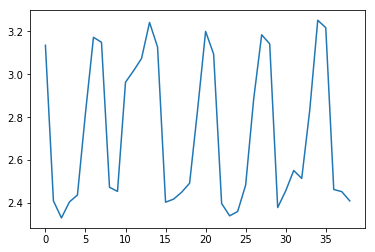

In [ ]:
plt.plot(testpreds[129])

In [ ]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [ ]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.701546   
air_0164b9927d20bcc3_2017-04-23              1.383373   
air_0241aa3964b7f861_2017-04-23              2.381328   
air_0328696196e46f18_2017-04-23              2.104326   
air_034a3d5b40d5b1b1_2017-04-23              3.524027   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.482414  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.988330  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.819258  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.201571  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.920750

In [ ]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [ ]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [ ]:
submission.to_csv("../submission/l4_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')